<a href="https://colab.research.google.com/github/aachen6/deepTC/blob/master/colab/deepTC_intensity_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepTC - Resnet for Intensity

The objective of *deepTC* can be found on [deepTC github page](https://github.com/aachen6/deepTC/), and the analysis is outlined below.
1. Data Preprocess
 - 1.1 [Satellite images and tracks of TC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_sync.ipynb)
 - 1.2 [Statistics of satellite images and tracks](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_stats.ipynb)

2. Model for TC Image
 - 2.1 [Post-binding architecture of TC image](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_image.ipynb)
 - 2.2 [CNN model for TC image classification ](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_cnn5.ipynb)
 - 2.3 [Resnet model for TC image classification](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_resnet.ipynb)
 - **2.4 [Resnet model for TC image intensity estimation](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_intensity_resnet.ipynb)**
 - 2.5 [Operation of TC image prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_image_prediction.ipynb)

3. Model for TC Track
 - 3.1 [Post-binding architecture of TC track](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_track.ipynb)
 - 3.2 [LSTM model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstm.ipynb)
 - 3.3 [LSTM model with attention for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstm.ipynb) 
 - 3.4 [LSTM-CNN model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstmcnn.ipynb)

4. Generative Model for TC Image
 - 4.1 [DCGAN model for deepTC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_generative_dcgan.ipynb)
 - 4.2 [SAGAN model for deepTC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_generative_sagan.ipynb)

In the [previous notebook](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_resnet.ipynb), we demonstrated the implementation and training of residual network for the classification of the TC satellite images. This notebook reuses the model for TC intensity estimation through simply redefinding the model objective and target parameter as the wind speed in the configuration file. WIthout further due, let's get started with module loading.

In [0]:
!pip install import-ipynb

In [0]:
import os 
import yaml
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

work_dir = r'/content/drive/My Drive/Colab Notebooks/deepTC'
p_data  = work_dir + os.sep + 'data/AL'
p_image = work_dir + os.sep + 'image/AL'
p_model = work_dir + os.sep + 'model/tc_intensity'

# load class defined in other ipynb
import import_ipynb
model_ipynb = work_dir + os.sep + 'deepTC_net_image.ipynb'
with open(model_ipynb, 'rb') as fp:
    with open('deepTC_net_lib.ipynb','wb') as fout:
       fout.write(fp.read())
  
import deepTC_net_lib
#force reload in case of error 
import importlib  
importlib.reload(deepTC_net_lib)
from deepTC_net_lib import YML2ModelNet, ImageDataSet, ImageTrainer, ImageInference


###Training and Validation

The network architecture is nearly the same as the *Resnet* defined in the [previous notebook](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_resnet.ipynb) for the classfication of the TC satellite images. In summary, the model consists in sequential layers of i) convolution layer with 5 x 5 filters that maps greyscale image into 32 channels and reduces the feature map size by a factor of four using *maxpool2d* function with stride of 2; ii) two consective residual blocks with each having one convolution layer that doubles the channel size and one with constant channel size and *ReLU* activation; iii) *avgpool2d* layer with reduction factor of 16; iv) two consective fully connected layers that transform the feature space into the target, i.e. wind speed. 

Since the wind speed correponds well to the category of the storm, the dataset split in a similar way as before to preserve the ratio of different classes in training, validation, and testing datefsets. The wind speed is normalized and appended to the original dataset based on normal distribuation with mean of 61.1 knots and standard deviation of 26.5 knots. For the training, the model objective is changed to be regression with target column being wind speed in the  dataset. Similarly, the model is trained with 15 epochs with a batch size of 64, and the training log is shown below. The model achieved a best mean absolute prediction error of 0.226 on the validation dataset, corresponding to an actual error of 6 knots.

In [0]:
import torch 
from torchvision.transforms import transforms

torch.cuda.empty_cache()

work_dir = r'/content/drive/My Drive/Colab Notebooks/deepTC'
p_data  = work_dir + os.sep + 'data/AL'
p_image = work_dir + os.sep + 'image/AL'
p_model = work_dir + os.sep + 'model/tc_intensity'

# load configuration file
f_config = p_model + os.sep + 'config_resnet_regression.yaml'
with open(f_config, 'r') as fp: config = yaml.load(fp)

# contruct the model
storm_resnet = YML2ModelNet(config, 'resnet')

# update path for config
config_params = config['params']
config_params['f_image_zip'] = p_image + os.sep + config_params['f_image_zip']
config_params['f_storm_msg'] = p_data  + os.sep + config_params['f_storm_msg']
config_params['f_data_yml']  = p_model + os.sep + config_params['f_data_yml']
config_params['f_state_yml'] = p_model + os.sep + config_params['f_state_yml']
config_params['f_model_pth'] = p_model + os.sep + config_params['f_model_pth']
config_params['f_test_yml']  = p_model + os.sep + config_params['f_test_yml']

# normalize data 
def scaler_normal(x):
    x_norm = (x - x.mean())/x.std()
    return x_norm 

# for simplicity, the target value is normalized in the input table
pd_data = pd.read_msgpack(config_params['f_storm_msg'])
# pd_data['win_org'] = pd_data['win']
# win = pd_data['win_org'].values
# pd_data['win'] = scaler_normal(win)
# pd_data.to_msgpack(config_params['f_storm_msg'])

# print the normalization factor for inverse normal
print(pd_data.describe())

# normalization is based on ramdon 1000 samples for this test
image_transforms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.456,), (0.222,))])

# dataset
storm_data = ImageDataSet(config_params, image_transforms, hotstart=False)
data_split = storm_data.load_data()

# model
storm_train = ImageTrainer(config_params, storm_resnet, hotstart=False)

# train & valid
storm_train.train_loop(data_split)



                win       win_org
count  5.042800e+04  50428.000000
mean   8.592450e-16     61.059828
std    1.000010e+00     26.491270
min   -1.738697e+00     15.000000
25%   -7.949803e-01     40.000000
50%   -2.287504e-01     55.000000
75%    5.262228e-01     75.000000
max    3.734859e+00    160.000000
------------------------------------
summary of dataset
------------------------------------
               train     valid      test
percent         0.72      0.18      0.10
size           36303      9080      5045
batch            567       141        78
------------------------------------
summary of GPU
------------------------------------
Tesla K80
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB
------------------------------------
training
------------------------------------


------------------------------------
summary of epoch: 0
------------------------------------
loss -           train     valid
                 0.745     0.614
accuracy/error - 
                 0.650     0.596
 


------------------------------------
summary of epoch: 1
------------------------------------
loss -           train     valid
                 0.567     0.504
accuracy/error - 
                 0.580     0.558
 


------------------------------------
summary of epoch: 2
------------------------------------
loss -           train     valid
                 0.463     0.392
accuracy/error - 
                 0.524     0.486
 


------------------------------------
summary of epoch: 3
------------------------------------
loss -           train     valid
                 0.328     0.280
accuracy/error - 
                 0.440     0.409
 


------------------------------------
summary of epoch: 4
------------------------------------
loss -           train     valid
                 0.240     0.225
accuracy/error - 
                 0.374     0.367
 


------------------------------------
summary of epoch: 5
------------------------------------
loss -           train     valid
                 0.184     0.186
accuracy/error - 
                 0.328     0.334
 


------------------------------------
summary of epoch: 6
------------------------------------
loss -           train     valid
                 0.146     0.147
accuracy/error - 
                 0.292     0.290
 


------------------------------------
summary of epoch: 7
------------------------------------
loss -           train     valid
                 0.114     0.134
accuracy/error - 
                 0.258     0.280
 


------------------------------------
summary of epoch: 8
------------------------------------
loss -           train     valid
                 0.095     0.120
accuracy/error - 
                 0.236     0.264
 


------------------------------------
summary of epoch: 9
------------------------------------
loss -           train     valid
                 0.079     0.117
accuracy/error - 
                 0.216     0.261
 


------------------------------------
summary of epoch: 10
------------------------------------
loss -           train     valid
                 0.068     0.096
accuracy/error - 
                 0.201     0.233
 


------------------------------------
summary of epoch: 11
------------------------------------
loss -           train     valid
                 0.058     0.101
accuracy/error - 
                 0.186     0.239
 


------------------------------------
summary of epoch: 12
------------------------------------
loss -           train     valid
                 0.047     0.092
accuracy/error - 
                 0.168     0.226
 


------------------------------------
summary of epoch: 13
------------------------------------
loss -           train     valid
                 0.042     0.101
accuracy/error - 
                 0.160     0.238
 


------------------------------------
summary of epoch: 14
------------------------------------
loss -           train     valid
                 0.039     0.091
accuracy/error - 
                 0.154     0.223
 


###Test Performance

On the test performance of the model, the mean absolute error is 6.0 knots with a standard deviation of 5.4 knots and the maximum error of 74 knots. The histograms of the predicted and target wind speed, and the absolute error of the test dataset are plotted in the figure blow, which shows that the error is not normally distributed but concentrated on the low end. This indicates the maximum error is associated with some anomalies. 

More specifically, histograms of the predicted and target wind speed and the absolute error for each category of TC are also plotted. The histogram of target wind speed is scatter as the wind speed reported has a resolution 5 knots. The overall mean absolute error of 6.0 knots is very close to this resolution, indicating the overall performance of the model is pretty good. The performance for categories with less samples is not as good as that with more samples since the histogram show more uniformity across the error range and spreads into larger error. 

        prediction       target          mae
count  5045.000000  5045.000000  5045.000000
mean     60.383850    61.162487     5.979302
std      22.756012    26.666098     5.427673
min      12.495682    15.024536     0.001022
25%      43.956436    40.033020     2.154339
50%      55.952530    55.038113     4.611328
75%      71.382484    75.044907     8.252144
max     150.735809   155.072052    74.342537


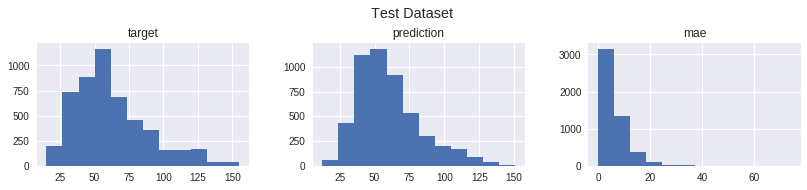

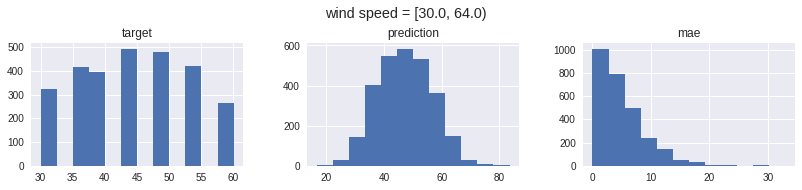

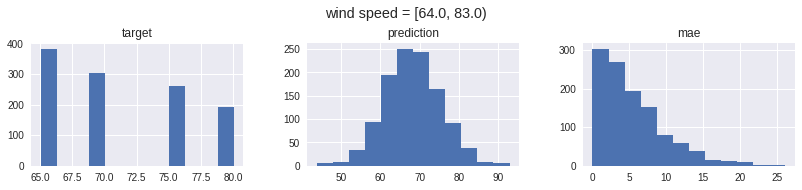

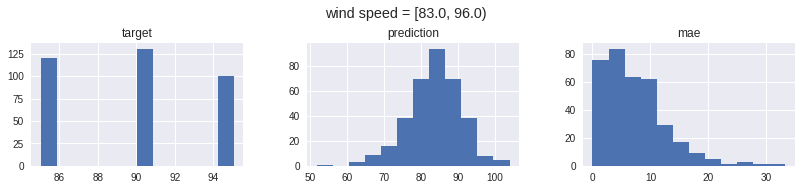

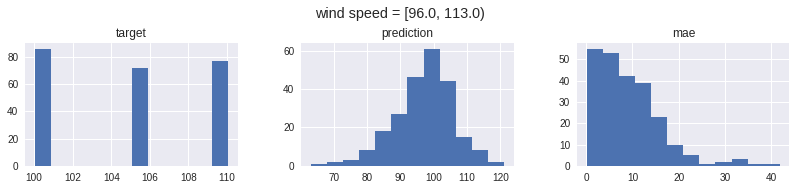

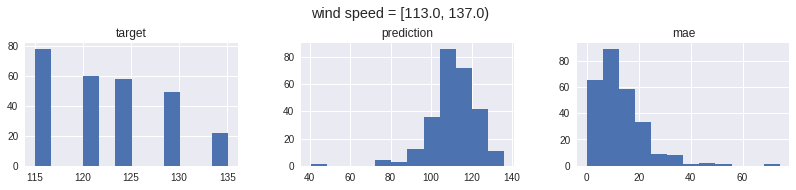

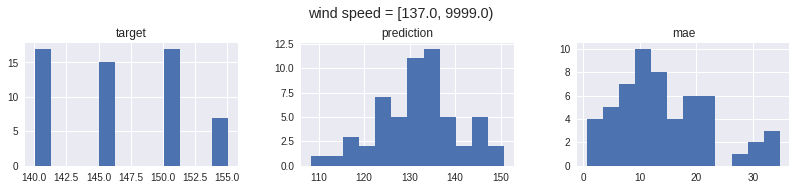

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import transforms

# load configuration file
f_config = p_model + os.sep + 'config_resnet_regression.yaml'
with open(f_config, 'r') as fp: config = yaml.load(fp)
  
# update path for config
config_params = config['params']
config_params['f_image_zip'] = p_image + os.sep + config_params['f_image_zip']
config_params['f_storm_msg'] = p_data  + os.sep + config_params['f_storm_msg']
config_params['f_data_yml']  = p_model + os.sep + config_params['f_data_yml']
config_params['f_state_yml'] = p_model + os.sep + config_params['f_state_yml']
config_params['f_model_pth'] = p_model + os.sep + config_params['f_model_pth']
config_params['f_test_yml']  = p_model + os.sep + config_params['f_test_yml']

image_transforms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.456,), (0.222,))])

# test
#storm_resnet = YML2ModelNet(config, 'resnet') # contruct the model
#storm_data = ImageDataSet(config_params, image_transforms, hotstart=True) # dataset
#data_split = storm_data.load_data()
#storm_train = ImageTrainer(config_params, storm_resnet, hotstart=True) # test
#test_results = storm_train.test_loop(data_split)
f_test = config_params['f_test_yml']
with open(f_test, 'r') as fp: test_results = yaml.load(fp)
  
#normalization factor for target
mean = 61.1;   std  = 26.5
test_idxs     = test_results['idxs']
test_targets  = test_results['labels'].flatten()*std + mean
test_predicts = test_results['predicts'].flatten()*std + mean


def _plot(title, pd_data):
  fig, axes = plt.subplots(1,3, figsize=(12,3))
  plt.tight_layout(pad=3)
  plt.suptitle(title)
  pd_data.hist('target', bins=12, ax=axes[0])     
  pd_data.hist('prediction', bins=12, ax=axes[1]) 
  pd_data.hist('mae', bins=12, ax=axes[2])   
  
#test summary
error = np.abs(test_predicts-test_targets) # mae error 
table = np.transpose(np.vstack((test_predicts, test_targets, error)))
pd_table = pd.DataFrame(table, columns=['prediction', 'target', 'mae'])
print(pd_table.describe())

_plot('Test Dataset', pd_table)
wins  = np.array([30, 64, 83, 96, 113, 137, 9999])
for i in range(len(wins)-1):
  pd_filter = pd_table[(pd_table['target']>=wins[i]) & (pd_table['target']<wins[i+1])]
  title = 'wind speed = [{0:.1f}, {1:.1f})'.format(wins[i], wins[i+1])
  _plot(title, pd_filter)